<a href="https://colab.research.google.com/github/aaaksenova/NLP_ABSA_project/blob/change/aspect_extraction_as_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестирование разных классификаторов

In [1]:
import pandas as pd

In [2]:
! pip install stanza
! pip install -U 'scikit-learn<0.24'

     |████████████████████████████████| 432 kB 21.9 MB/s 
     |████████████████████████████████| 170 kB 54.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=e0a09605edcb1924e18d9baf7b468d59df3208945b5aab45c61b7c8378c7787e
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 6.8 MB 27.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
import stanza

In [4]:
stanza.download('ru')

2021-12-27 06:30:04 INFO: Downloading default packages for language: ru (Russian)...


2021-12-27 06:30:30 INFO: Finished downloading models and saved to /root/stanza_resources.


In [5]:
nlp = stanza.Pipeline('ru', processors='tokenize,pos')

2021-12-27 06:30:30 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |

2021-12-27 06:30:30 INFO: Use device: cpu
2021-12-27 06:30:30 INFO: Loading: tokenize
2021-12-27 06:30:30 INFO: Loading: pos
2021-12-27 06:30:30 INFO: Done loading processors!


In [6]:
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [7]:
def bio_tagger(reviews, aspects):
    """
    Takes reviews and aspects as an input and returns
    dataframe with text id, pos, start, end and bio tag for each token
    """
    
    texts = []
    bios = []
    poses = []
    start_chars = []
    end_chars = []
    text_ids = []
    for text_id, text in tqdm(reviews.items()):
        processed = nlp(text)
        text_data = []
        bio_data = []
        pos_data = []
        for token in processed.iter_tokens():
            add = False
            for mention in aspects[text_id]:
                if token.start_char == int(mention['start']) and \
                token.end_char <= int(mention['end']):
                    text_data.append(token.text)
                    bio_data.append('B-'+mention['category'])
                    pos_data.append(token.words[0].pos)
                    start_chars.append(token.start_char)
                    end_chars.append(token.end_char)
                    text_ids.append(text_id)
                    add = True
                elif token.start_char > int(mention['start']) and \
                token.end_char <= int(mention['end']):
                    text_data.append(token.text)
                    bio_data.append('I-'+mention['category'])
                    pos_data.append(token.words[0].pos)
                    start_chars.append(token.start_char)
                    end_chars.append(token.end_char)
                    text_ids.append(text_id)
                    add = True
            if not add:
                  text_data.append(token.text)
                  bio_data.append('O')
                  pos_data.append(token.words[0].pos)
                  start_chars.append(token.start_char)
                  end_chars.append(token.end_char)
                  text_ids.append(text_id)
        texts.extend(text_data)
        bios.extend(bio_data)
        poses.extend(pos_data)
    df = pd.DataFrame({'Text ID' : text_ids, 'Word' : texts, 'POS' : poses, 
                       'Tag' : bios, 'Start' : start_chars, 'End': end_chars})
    return df

## Препроцессинг трейна

In [8]:
# Reading train like in SEM2
train_asp = pd.read_csv(
    'train_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
train_texts = pd.read_csv('train_reviews.txt', delimiter='\t', names=['text_id','text'])

In [9]:
train_texts

,text_id,text
0,3976,"День 8-го марта прошёл, можно и итоги подвести..."
1,30808,Отмечали в этом ресторане день рождение на пер...
2,14031,Хочу поделиться своим впечатлением от посещени...
3,2495,Добрый день! Были вчера с друзьями в этом кафе...
4,38835,Отметили с мужем годовщину свадьбы 6 ноября в ...
...,...,...
279,6962,Очаровательная Виктория просила об отзыве и я ...
280,9878,Пришли в данное заведение 4 июня 2014 года пок...
281,28258,Заехали с мужем поужинать в пятницу ( 17.01.14...
282,33043,Мне так там нравитсяяяя!!!!!!!!! Интерьер модн...


In [10]:
reviews = {}
with open('train_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews[line[0]] = line[1]

In [11]:
aspects = defaultdict(list)

In [12]:
with open('train_aspects.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    keys = ('category', 'mention', 'start', 'end', 'sentiment')
    aspects[line[0]].append(dict(zip(keys, line[1:])))

In [13]:
df = bio_tagger(reviews, aspects)

  0%|          | 0/284 [00:00<?, ?it/s]

In [14]:
df

,Text ID,Word,POS,Tag,Start,End
0,3976,День,NOUN,O,0,4
1,3976,8-го,ADJ,O,5,9
2,3976,марта,NOUN,O,10,15
3,3976,прошёл,VERB,O,16,22
4,3976,",",PUNCT,O,22,23
...,...,...,...,...,...,...
47238,16630,),PUNCT,O,373,374
47239,16630,),PUNCT,O,374,375
47240,16630,),PUNCT,O,375,376
47241,16630,),PUNCT,O,376,377


In [15]:
df.to_csv('bio_data_train.csv')  # Saving train data

In [16]:
df.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-Food,1877
1,B-Interior,686
2,B-Price,134
3,B-Service,1246
4,B-Whole,795
5,I-Food,959
6,I-Interior,189
7,I-Price,30
8,I-Service,283
9,I-Whole,187


In [17]:
X = df.drop('Tag', axis=1)
v = DictVectorizer(sparse=False)
v = v.fit(X.to_dict('records'))
X_train = v.transform(X.to_dict('records'))
y_train = df.Tag.values
classes = np.unique(y_train)
classes = classes.tolist()
X_train.shape, y_train.shape

((47243, 8325), (47243,))

## Препроцессинг теста

In [18]:
test_asp = pd.read_csv(
    'dev_aspects.txt', 
    delimiter='\t', 
    names=['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
)
test_texts = pd.read_csv('dev_reviews.txt', delimiter='\t', names=['text_id','text'])

In [19]:
reviews = {}
with open('dev_reviews.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    reviews[line[0]] = line[1]

In [20]:
aspects = defaultdict(list)

In [21]:
with open('dev_aspects.txt') as f:
  for line in f:
    line = line.rstrip('\r\n').split('\t')
    keys = ('category', 'mention', 'start', 'end', 'sentiment')
    # ['text_id', 'category', 'mention', 'start', 'end', 'sentiment']
    # тут можно отдельно запомнить начало и конец каждого упоминания
    aspects[line[0]].append(dict(zip(keys, line[1:])))

In [22]:
df_test = bio_tagger(reviews, aspects)

  0%|          | 0/71 [00:00<?, ?it/s]

In [23]:
df_test.to_csv('bio_data_dev.csv')

In [24]:
df_test.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-Food,449
1,B-Interior,176
2,B-Price,34
3,B-Service,338
4,B-Whole,185
5,I-Food,273
6,I-Interior,29
7,I-Price,11
8,I-Service,74
9,I-Whole,48


In [25]:
df_test

,Text ID,Word,POS,Tag,Start,End
0,13823,Зашли,VERB,O,0,5
1,13823,в,ADP,O,6,7
2,13823,"""",PUNCT,B-Whole,7,8
3,13823,аппетит,NOUN,I-Whole,8,15
4,13823,"""",PUNCT,I-Whole,15,16
...,...,...,...,...,...,...
11822,11770,",",PUNCT,O,1005,1006
11823,11770,ресторан,NOUN,B-Whole,1007,1015
11824,11770,высокого,ADJ,O,1016,1024
11825,11770,уровня,NOUN,O,1025,1031


In [26]:
X = df_test.drop('Tag', axis=1)
X_test = v.transform(X.to_dict('records'))
y_test = df_test.Tag.values
classes = np.unique(y_test)
classes = classes.tolist()
X_test.shape, y_test.shape

((11827, 8325), (11827,))

## Перцептрон

In [27]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 1070.46, NNZs: 953, Bias: -86.000000, T: 47243, Avg. loss: 7237.556633
Total training time: 0.80 seconds.
-- Epoch 1
Norm: 1398.38, NNZs: 1855, Bias: -309.000000, T: 47243, Avg. loss: 25658.505705
Total training time: 0.84 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s


Norm: 945.18, NNZs: 339, Bias: -41.000000, T: 47243, Avg. loss: 2279.635332
Total training time: 0.76 seconds.
-- Epoch 1
Norm: 1765.53, NNZs: 1479, Bias: -442.000000, T: 47243, Avg. loss: 15400.625553
Total training time: 0.83 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s


Norm: 970.28, NNZs: 976, Bias: -181.000000, T: 47243, Avg. loss: 9982.879072
Total training time: 0.78 seconds.
-- Epoch 1
Norm: 702.91, NNZs: 1190, Bias: -104.000000, T: 47243, Avg. loss: 14987.977690
Total training time: 0.81 seconds.
-- Epoch 1
Norm: 865.98, NNZs: 341, Bias: 29.000000, T: 47243, Avg. loss: 2115.672332
Total training time: 0.74 seconds.
-- Epoch 1
Norm: 1167.69, NNZs: 127, Bias: -20.000000, T: 47243, Avg. loss: 743.109709
Total training time: 0.73 seconds.
-- Epoch 1
Norm: 620.33, NNZs: 516, Bias: -23.000000, T: 47243, Avg. loss: 3098.207713
Total training time: 0.76 seconds.
-- Epoch 1
Norm: 1036.00, NNZs: 398, Bias: 25.000000, T: 47243, Avg. loss: 1654.863027
Total training time: 0.77 seconds.
Norm: 5620.36, NNZs: 3839, Bias: 952.000000, T: 47243, Avg. loss: 73930.088881
Total training time: 0.86 seconds.


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    4.7s finished


Perceptron(max_iter=5, n_jobs=-1, verbose=10)

In [28]:
new_classes = classes.copy()
new_classes.pop()
new_classes

['B-Food',
 'B-Interior',
 'B-Price',
 'B-Service',
 'B-Whole',
 'I-Food',
 'I-Interior',
 'I-Price',
 'I-Service',
 'I-Whole']

In [31]:
print(classification_report(y_pred=per.predict(X_test), y_true=y_test, labels=new_classes, zero_division=0))

              precision    recall  f1-score   support

      B-Food       0.00      0.00      0.00       449
  B-Interior       0.00      0.00      0.00       176
     B-Price       0.00      0.00      0.00        34
   B-Service       0.01      0.01      0.01       338
     B-Whole       0.00      0.00      0.00       185
      I-Food       0.00      0.00      0.00       273
  I-Interior       0.00      0.00      0.00        29
     I-Price       0.00      0.00      0.00        11
   I-Service       0.00      0.00      0.00        74
     I-Whole       0.00      0.00      0.00        48

   micro avg       0.01      0.00      0.00      1617
   macro avg       0.00      0.00      0.00      1617
weighted avg       0.00      0.00      0.00      1617



## SGDClassifier

In [45]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)

SGDClassifier()

In [47]:
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes, zero_division=0))

              precision    recall  f1-score   support

      B-Food       0.00      0.00      0.00       449
  B-Interior       0.00      0.00      0.00       176
     B-Price       0.00      0.09      0.00        34
   B-Service       0.00      0.00      0.00       338
     B-Whole       0.00      0.00      0.00       185
      I-Food       0.00      0.00      0.00       273
  I-Interior       0.00      0.00      0.00        29
     I-Price       0.00      0.00      0.00        11
   I-Service       0.00      0.00      0.00        74
     I-Whole       0.00      0.00      0.00        48

   micro avg       0.00      0.00      0.00      1617
   macro avg       0.00      0.01      0.00      1617
weighted avg       0.00      0.00      0.00      1617



## Наивный Байес

In [34]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)

MultinomialNB(alpha=0.01)

In [35]:
print(classification_report(y_pred=nb.predict(X_test), y_true=y_test, labels = new_classes))

              precision    recall  f1-score   support

      B-Food       0.75      0.94      0.83       449
  B-Interior       0.83      0.90      0.86       176
     B-Price       0.84      0.94      0.89        34
   B-Service       0.75      0.90      0.82       338
     B-Whole       0.71      0.89      0.79       185
      I-Food       0.68      0.65      0.66       273
  I-Interior       0.78      0.62      0.69        29
     I-Price       1.00      0.36      0.53        11
   I-Service       0.58      0.50      0.54        74
     I-Whole       0.81      0.71      0.76        48

   micro avg       0.74      0.83      0.79      1617
   macro avg       0.77      0.74      0.74      1617
weighted avg       0.74      0.83      0.78      1617



In [36]:
df_test['nb_predictions'] = nb.predict(X_test)

Добавим его результат в датасет, так как он вышел достаточно неплохим и побил бейзлайн

## CRF

In [44]:
! pip install sklearn_crfsuite

     |████████████████████████████████| 743 kB 25.3 MB/s 


In [48]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [49]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Text ID').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        self.text_ids = self.data['Text ID'].unique()

    # Функция восстанавливает порядок после аггрегации    
    def get_next(self):
        s = []
        for i in self.text_ids:
            s.append(self.grouped['{}'.format(self.text_ids[self.n_sent])])
            self.n_sent += 1
        return s
            
getter_train = SentenceGetter(df)
sentences_train = getter_train.get_next()
getter_test = SentenceGetter(df_test)
sentences_test = getter_test.get_next()

In [50]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features
    
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for token, postag, label in sent]
def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [51]:
X_train = [sent2features(s) for s in sentences_train]
y_train = [sent2labels(s) for s in sentences_train]
X_test = [sent2features(s) for s in sentences_test]
y_test = [sent2labels(s) for s in sentences_test]

In [52]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [53]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=new_classes))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-Food', 'B-Interior', 'B-Price', 'B-Service', 'B-Whole', 'I-Food', 'I-Interior', 'I-Price', 'I-Service', 'I-Whole'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

      B-Food       0.93      0.96      0.95       449
  B-Interior       0.98      0.93      0.95       176
     B-Price       0.97      0.97      0.97        34
   B-Service       0.97      0.90      0.93       338
     B-Whole       0.93      0.94      0.94       185
      I-Food       0.99      0.99      0.99       273
  I-Interior       0.85      1.00      0.92        29
     I-Price       1.00      1.00      1.00        11
   I-Service       0.96      0.91      0.93        74
     I-Whole       1.00      0.98      0.99        48

   micro avg       0.96      0.95      0.95      1617
   macro avg       0.96      0.96      0.96      1617
weighted avg       0.96      0.95      0.95      1617



In [54]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
7.677652 B-Service word.lower():обслуживание
5.508532 B-Service word.lower():обслуживанием
5.289595 B-Price  word.lower():цены
5.067106 B-Food   word.lower():поужинать
4.768833 B-Service word.lower():официантов
4.521608 B-Service word.lower():обслуживании
4.519252 B-Food   word.lower():ужинали
4.348849 B-Food   word.lower():мороженого
4.229795 B-Interior word.lower():потанцевать
4.168452 B-Food   word.lower():порции
4.096222 B-Service word.lower():обслуживания
4.068622 B-Whole  word.lower():заведение
4.050946 B-Food   word.lower():шампанское
4.040807 B-Service word.lower():официантки
4.029295 B-Food   word.lower():мороженое
3.970551 B-Service word.lower():администратора
3.949888 O        -1:word.lower():живая
3.858418 B-Service word.lower():официантка
3.853843 B-Service word.lower():сотрудники
3.845189 B-Whole  word.lower():заведению
3.836636 B-Food   word.lower():пили
3.816438 B-Food   word.lower():паста
3.805998 B-Whole  word.lower():заведении
3.805417 B-Price  word.low

In [55]:
df_test

,Text ID,Word,POS,Tag,Start,End,nb_predictions
0,13823,Зашли,VERB,O,0,5,O
1,13823,в,ADP,O,6,7,O
2,13823,"""",PUNCT,B-Whole,7,8,I-Whole
3,13823,аппетит,NOUN,I-Whole,8,15,I-Whole
4,13823,"""",PUNCT,I-Whole,15,16,I-Whole
...,...,...,...,...,...,...,...
11822,11770,",",PUNCT,O,1005,1006,O
11823,11770,ресторан,NOUN,B-Whole,1007,1015,B-Whole
11824,11770,высокого,ADJ,O,1016,1024,O
11825,11770,уровня,NOUN,O,1025,1031,O


In [56]:
crf_preds = []
for i in y_pred:
   crf_preds.extend(i)

In [57]:
df_test['crf_predictions'] = crf_preds

In [58]:
df_test.to_csv('bio_data_dev_preds.csv') # Saving data

## Back transformation of BIO predictions

In [59]:
df_predicted = df_test[df_test.Tag != 'O']

In [60]:
df_predicted

,Text ID,Word,POS,Tag,Start,End,nb_predictions,crf_predictions
2,13823,"""",PUNCT,B-Whole,7,8,I-Whole,B-Whole
3,13823,аппетит,NOUN,I-Whole,8,15,I-Whole,I-Whole
4,13823,"""",PUNCT,I-Whole,15,16,I-Whole,I-Whole
32,13823,встретил,VERB,B-Service,138,146,B-Service,B-Service
33,13823,менеджер,NOUN,B-Service,147,155,B-Service,B-Service
...,...,...,...,...,...,...,...,...
11809,11770,сырым,ADJ,I-Food,925,930,I-Food,I-Food
11810,11770,яйцом,NOUN,I-Food,931,936,I-Food,I-Food
11812,11770,Официанты,NOUN,B-Service,938,947,B-Service,B-Service
11817,11770,обстановкая,ADJ,B-Service,976,987,B-Service,B-Service


In [61]:
df_predicted.drop(['POS', 'Tag'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [62]:
df_predicted

,Text ID,Word,Start,End,nb_predictions,crf_predictions
2,13823,"""",7,8,I-Whole,B-Whole
3,13823,аппетит,8,15,I-Whole,I-Whole
4,13823,"""",15,16,I-Whole,I-Whole
32,13823,встретил,138,146,B-Service,B-Service
33,13823,менеджер,147,155,B-Service,B-Service
...,...,...,...,...,...,...
11809,11770,сырым,925,930,I-Food,I-Food
11810,11770,яйцом,931,936,I-Food,I-Food
11812,11770,Официанты,938,947,B-Service,B-Service
11817,11770,обстановкая,976,987,B-Service,B-Service


In [63]:
entity_set = []
textid = 0
cur_start = 0
cur_end = 0
cur_word = ''
cur_tag = ''
typ = ''
for index, row in df_predicted.iterrows():
    if row.crf_predictions == 'O':
        continue
    typ, tag = row.crf_predictions.split('-')
    if typ == 'B':
        if cur_word:
            entity_set.append((str(cur_text), cur_tag, cur_word, str(cur_start), str(cur_end)))
        cur_text = row['Text ID']
        cur_tag = tag
        cur_word = row.Word
        cur_start = int(row.Start)
        cur_end = int(row.End)
    elif typ == 'I':
        cur_word = cur_word + ' ' * (int(row.Start) - cur_end) + row.Word
        cur_end = int(row.End)
entity_set.append((str(cur_text), cur_tag, cur_word, str(cur_start), str(cur_end)))

In [64]:
with open('dev_pred_aspects.txt', 'w')as fw:
    for ent in entity_set:
        fw.write('\t'.join(ent) + '\n')

In [65]:
entity_set = []
textid = 0
cur_start = 0
cur_end = 0
cur_word = ''
cur_tag = ''
typ = ''
for index, row in df_predicted.iterrows():
    if row.nb_predictions == 'O':
        continue
    typ, tag = row.nb_predictions.split('-')
    if typ == 'B':
        if cur_word:
            entity_set.append((str(cur_text), cur_tag, cur_word, str(cur_start), str(cur_end)))
        cur_text = row['Text ID']
        cur_tag = tag
        cur_word = row.Word
        cur_start = int(row.Start)
        cur_end = int(row.End)
    elif typ == 'I':
        cur_word = cur_word + ' ' * (int(row.Start) - cur_end) + row.Word
        cur_end = int(row.End)
entity_set.append((str(cur_text), cur_tag, cur_word, str(cur_start), str(cur_end)))

In [66]:
with open('dev_pred_aspects_nb.txt', 'w')as fw:
    for ent in entity_set:
        fw.write('\t'.join(ent) + '\n')

## Анализ ошибок CRF

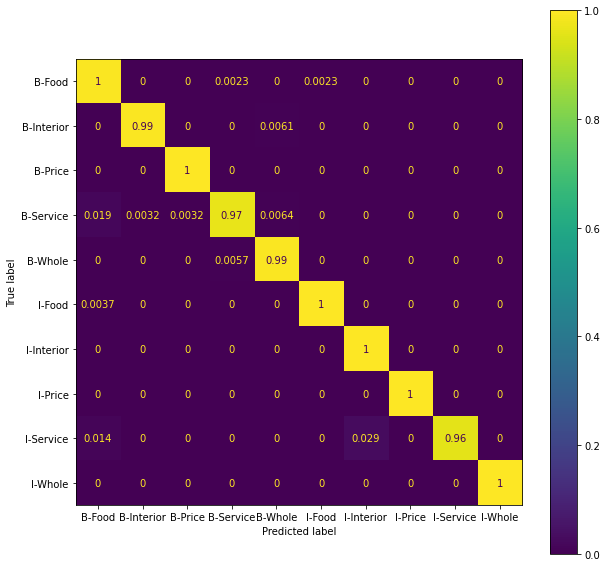

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(df_test.Tag.tolist(), df_test.crf_predictions.tolist(), normalize='true', labels=new_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=new_classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

In [83]:
df_test[df_test['Tag'] != df_test['crf_predictions']].head(30)

,Text ID,Word,POS,Tag,Start,End,nb_predictions,crf_predictions
86,13823,заведения,NOUN,B-Service,431,440,B-Whole,O
263,1427,бесплатной,ADJ,B-Price,647,657,B-Price,O
313,1427,помогает,VERB,B-Service,927,935,B-Service,O
415,16714,),PUNCT,I-Food,173,174,O,O
669,797,Чаевые,ADJ,B-Service,645,651,O,O
700,34710,несли,VERB,B-Service,129,134,O,O
707,34710,салат,NOUN,B-Service,162,167,B-Food,B-Food
728,34710,Меню,NOUN,O,258,262,B-Food,B-Food
751,34710,дали,VERB,B-Service,362,366,B-Service,O
801,34710,принесла,VERB,B-Service,626,634,B-Service,O


In [84]:
df_test[df_test['Tag'] != df_test['crf_predictions']].shape[0]

138

Всего CRF сделал 138 ошибок. В принципе в некоторых местах есть спорные моменты, например, слова "еда" и "кухня" в датасете без тега аспекта, слово "ресторан" без тега whole. Я бы больше согласилась в этом плане с CRF чем с разметкой

## Анализ ошибок Наивный Байес

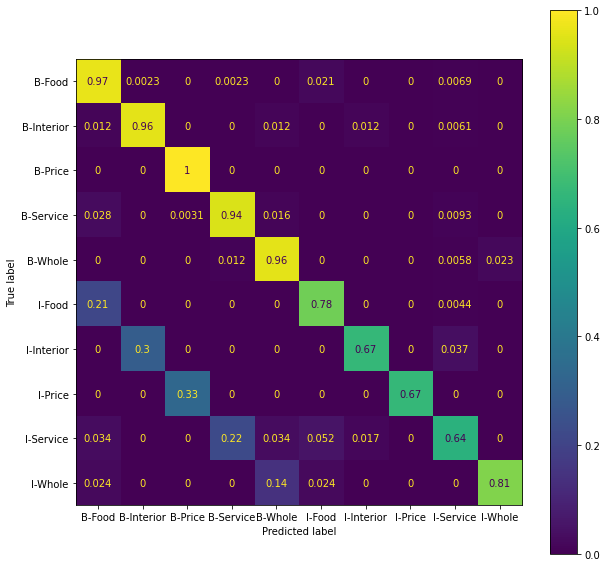

In [88]:
cm = confusion_matrix(df_test.Tag.tolist(), df_test.nb_predictions.tolist(), normalize='true', labels=new_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=new_classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

In [85]:
df_test[df_test['Tag'] != df_test['nb_predictions']].head(30)

,Text ID,Word,POS,Tag,Start,End,nb_predictions,crf_predictions
2,13823,"""",PUNCT,B-Whole,7,8,I-Whole,B-Whole
40,13823,к,ADP,I-Service,198,199,O,I-Service
66,13823,ждать,VERB,O,315,320,B-Service,O
86,13823,заведения,NOUN,B-Service,431,440,B-Whole,O
125,13823,меню,NOUN,B-Food,639,643,I-Service,B-Food
131,13823,качество,NOUN,O,671,679,B-Food,O
192,1427,отношение,NOUN,O,255,264,B-Service,O
225,1427,столов,NOUN,O,443,449,B-Interior,O
234,1427,столика,NOUN,O,492,499,I-Service,O
284,1427,знала,VERB,O,748,753,B-Service,O


In [86]:
df_test[df_test['Tag'] != df_test['nb_predictions']].shape[0]

603

Наивный байес ошибся 603 раза. Он часто классифицирует глаголы и отглагольные слова как Сервис, при том, что в оригинале они так не размечены. Кроме того, он плохо справляется с пунктуацией. Например, когда аспект в скобках. На confision матрице видно, что путаются B и I теги внутри категории